# Definition of the model

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split, DataLoader
import matplotlib.pyplot as plt
from constants import *
from GTZAN import GTZAN
from visualization import *
import time
import datetime

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

Device: cuda


In [2]:
class BeatTracker(nn.Module):
    
    def __init__(self, hidden_size=128, num_layers=2):
        super(BeatTracker, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(
                        nb, 
                        hidden_size, 
                        num_layers, 
                        bidirectional=True, 
                        dropout=0.5,
                        batch_first=True)
        self.hid_to_beat = nn.Linear(2 * hidden_size, 2)
        self.hidden = None
        
        self.loss_function = nn.NLLLoss()
        
        self.lr = 0.003
        self.optimizer = optim.Adam(self.parameters(), lr=self.lr)

    def forward(self, spec):
        x = self.lstm(spec)[0]
        x = self.hid_to_beat(x)
        x = F.log_softmax(x, dim=-1)
        return x
    
    def set_lr(self, lr):
        self.lr = lr
        for p in self.optimizer.param_groups:
            p['lr'] = lr
            
    def learn(self, spec, onsets, isbeat):
        self.optimizer.zero_grad()
        output = self(spec)
        output = output[onsets == 1]
        target = isbeat[onsets == 1]
        loss = self.loss_function(output, target)
        loss.backward()
        self.optimizer.step()
        
        predic = torch.argmax(output, dim=1)
        accuracy = torch.sum(predic == target).item() / predic.shape.numel()
        
        return loss.item(), accuracy
    
    def fit(self, dataset, batch_size=1, epochs=1):
        loss_hist = np.zeros((epochs, -(-len(dataset) // batch_size)))
        accu_hist = np.zeros((epochs, -(-len(dataset) // batch_size)))
        for e in range(epochs):
            start = time.time()
            
            dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
            for i, (spec, onsets, isbeat) in enumerate(dataloader):
                loss, accuracy = self.learn(spec, onsets, isbeat)
                loss_hist[e, i] = loss
                accu_hist[e, i] = accuracy
            
            end = time.time()
            t = end - start
            eta = str(datetime.timedelta(seconds=int(t * (epochs - e - 1))))
            print(f'| Epoch: {e + 1:{len(str(epochs))}} | ', end='')
            print(f'Loss: {np.mean(loss_hist[e]):7.4f} | ', end='')
            print(f'Accuracy: {np.mean(accu_hist[e]):5.4f} | ', end='')
            print(f'{t / len(dataloader):.2f} s/b | Eta: {eta} |')
        return loss_hist, accu_hist
    
    def predict(self, specs, onsets):
        """So far only works if batch_size = 1"""
        with torch.no_grad():
            output = model(specs)
            output = output[onsets == 1]
            pred_t = torch.argmax(output, dim=1)
            onsets_frames = np.argwhere(onsets.squeeze(0) == 1).squeeze(0)
            beats_frames = onsets_frames[pred_t == 1]
            pred = torch.zeros_like(onsets)
            pred[:, beats_frames] = 1
        return pred
    
    def evaluate(self, specs, onsets, isbeat):
        with torch.no_grad():
            output = model(specs)
            output = output[onsets == 1]
            target = isbeat[onsets == 1]
            predic = torch.argmax(output, dim=1)
            
            tn = torch.sum((predic == 0) & (target == 0)).item()
            fp = torch.sum((predic == 1) & (target == 0)).item()
            fn = torch.sum((predic == 0) & (target == 1)).item()
            tp = torch.sum((predic == 1) & (target == 1)).item()
        return tn, fp, fn, tp
    
    def evaluate_from_dataset(self, dataset):
        dataloader = DataLoader(dataset, batch_size=1)
        ttn = 0
        tfp = 0
        tfn = 0
        ttp = 0
        for specs, onsets, isbeat in dataloader:
            tn, fp, fn, tp = self.evaluate(specs, onsets, isbeat)
            ttn += tn
            tfp += fp
            tfn += fn
            ttp += tp
        return ttn, tfp, tfn, ttp
    
    def freeze(self):
        for p in self.parameters():
            p.requires_grad = False
            
    def unfreeze(self):
        for p in self.parameters():
            p.requires_grad = True

class ToTensor(object):
    
    def __call__(self, sample):
        spec_np, onsets_np, isbeat_np = sample
        
        # Normalize to [-1, 1]
        spec_np = 2 * (spec_np - spec_np.min()) / (spec_np.max() - spec_np.min()) - 1
        spec = torch.tensor(spec_np.T, dtype=torch.float, device=device)
        
        onsets = torch.zeros(spec.shape[0], dtype=torch.long, device=device)
        isbeat = torch.zeros(spec.shape[0], dtype=torch.long, device=device)
        
        onsets[onsets_np] = 1
        isbeat[onsets_np[isbeat_np == 1]] = 1
        
        return spec, onsets, isbeat

totensor = ToTensor()
    
def beat_track(isbeat):
    onset_envelope = isbeat.squeeze(0).numpy()
    tempo, bt = librosa.beat.beat_track(
                            sr=sr, 
                            onset_envelope=onset_envelope, 
                            hop_length=hl, 
                            tightness=800)
    return bt

# Visualization of the dataset

Take a subset of the GTZAN dataset preprocessed using `preprocess-GTZAN` and split it into a train set and a validation set.

In [ ]:
dataset = GTZAN(937, 'country', 20, getbeats=True)

Visualize an example.

In [ ]:
spec, onsets, isbeat, beats = dataset[np.random.randint(len(dataset))]

In [ ]:
showspec(spec)

In [ ]:
showdata(spec, onsets, isbeat, beats, duration=10)

# Find learning rate

In [13]:
model = BeatTracker(hidden_size=256, num_layers=3)
model.to(device)
print_params(model)

 ----------------------------------------------------------
| lstm.weight_ih_l0            | [1024, 229]  |    234,496 |
| lstm.weight_hh_l0            | [1024, 256]  |    262,144 |
| lstm.bias_ih_l0              | [1024]       |      1,024 |
| lstm.bias_hh_l0              | [1024]       |      1,024 |
| lstm.weight_ih_l0_reverse    | [1024, 229]  |    234,496 |
| lstm.weight_hh_l0_reverse    | [1024, 256]  |    262,144 |
| lstm.bias_ih_l0_reverse      | [1024]       |      1,024 |
| lstm.bias_hh_l0_reverse      | [1024]       |      1,024 |
| lstm.weight_ih_l1            | [1024, 512]  |    524,288 |
| lstm.weight_hh_l1            | [1024, 256]  |    262,144 |
| lstm.bias_ih_l1              | [1024]       |      1,024 |
| lstm.bias_hh_l1              | [1024]       |      1,024 |
| lstm.weight_ih_l1_reverse    | [1024, 512]  |    524,288 |
| lstm.weight_hh_l1_reverse    | [1024, 256]  |    262,144 |
| lstm.bias_ih_l1_reverse      | [1024]       |      1,024 |
| lstm.bias_hh_l1_reverse

In [14]:
dataset = GTZAN(transform=totensor)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)
n_mb = len(dataloader) # number of minibatches
lr = (10. ** -np.arange(0, 5, 5 / n_mb))[::-1]

In [15]:
losses = np.zeros(n_mb)
for i, (specs, onsets, isbeat) in enumerate(dataloader):
    print(f'{i + 1}/{n_mb}')
    model.set_lr(lr[i])
    loss, accuracy = model.learn(specs, onsets, isbeat)
    losses[i] = loss

1/125
2/125
3/125
4/125
5/125
6/125
7/125
8/125
9/125
10/125
11/125
12/125
13/125
14/125
15/125
16/125
17/125
18/125
19/125
20/125
21/125
22/125
23/125
24/125
25/125
26/125
27/125
28/125
29/125
30/125
31/125
32/125
33/125
34/125
35/125
36/125
37/125
38/125
39/125
40/125
41/125
42/125
43/125
44/125
45/125
46/125
47/125
48/125
49/125
50/125
51/125
52/125
53/125
54/125
55/125
56/125
57/125
58/125
59/125
60/125
61/125
62/125
63/125
64/125
65/125
66/125
67/125
68/125
69/125
70/125
71/125
72/125
73/125
74/125
75/125
76/125
77/125
78/125
79/125
80/125
81/125
82/125
83/125
84/125
85/125
86/125
87/125
88/125
89/125
90/125
91/125
92/125
93/125
94/125
95/125
96/125
97/125
98/125
99/125
100/125
101/125
102/125
103/125
104/125
105/125
106/125
107/125
108/125
109/125
110/125
111/125
112/125
113/125
114/125
115/125
116/125
117/125
118/125
119/125
120/125
121/125
122/125
123/125
124/125
125/125


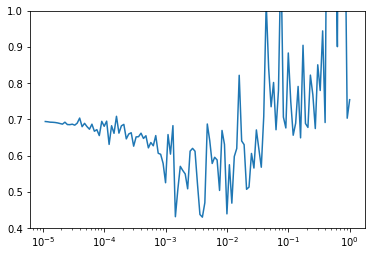

In [16]:
plt.ylim(0.4, 1)
plt.semilogx(lr, losses);

In [17]:
def moving_average(a, n):
    """Copied from https://stackoverflow.com/a/14314054"""
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [18]:
n = 5
av_losses = moving_average(losses, n)
av_lr = lr[n-1:]

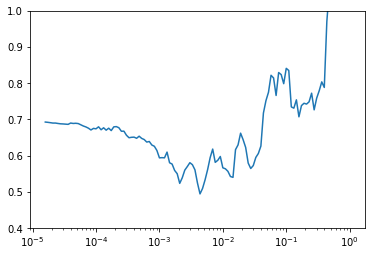

In [19]:
plt.ylim(0.4, 1)
plt.semilogx(av_lr, av_losses);

Something like `lr = 0.001` seems like a good choice.

# Training of the model

In [21]:
model = BeatTracker(hidden_size=256, num_layers=3)
model.to(device)
print_params(model)

 ----------------------------------------------------------
| lstm.weight_ih_l0            | [1024, 229]  |    234,496 |
| lstm.weight_hh_l0            | [1024, 256]  |    262,144 |
| lstm.bias_ih_l0              | [1024]       |      1,024 |
| lstm.bias_hh_l0              | [1024]       |      1,024 |
| lstm.weight_ih_l0_reverse    | [1024, 229]  |    234,496 |
| lstm.weight_hh_l0_reverse    | [1024, 256]  |    262,144 |
| lstm.bias_ih_l0_reverse      | [1024]       |      1,024 |
| lstm.bias_hh_l0_reverse      | [1024]       |      1,024 |
| lstm.weight_ih_l1            | [1024, 512]  |    524,288 |
| lstm.weight_hh_l1            | [1024, 256]  |    262,144 |
| lstm.bias_ih_l1              | [1024]       |      1,024 |
| lstm.bias_hh_l1              | [1024]       |      1,024 |
| lstm.weight_ih_l1_reverse    | [1024, 512]  |    524,288 |
| lstm.weight_hh_l1_reverse    | [1024, 256]  |    262,144 |
| lstm.bias_ih_l1_reverse      | [1024]       |      1,024 |
| lstm.bias_hh_l1_reverse

In [22]:
dataset = GTZAN(transform=totensor)

train_size = int(0.8 * len(dataset))
valid_size = len(dataset) - train_size
trainset, validset = random_split(dataset, [train_size, valid_size])

print(f'Train size: {train_size}')
print(f'Valid size: {valid_size}')

Train size: 800
Valid size: 200


In [23]:
confusion(*model.evaluate_from_dataset(validset))

 -----------------------
| tp:  9499 | fp: 13399 |
| fn:    14 | tn:    20 |
 -----------------------
Precision: 0.4148
   Recall: 0.9985
 Accuracy: 0.4151


In [24]:
confusion(*model.evaluate_from_dataset(trainset))

 -----------------------
| tp: 37235 | fp: 55897 |
| fn:    65 | tn:    99 |
 -----------------------
Precision: 0.3998
   Recall: 0.9983
 Accuracy: 0.4002


In [25]:
model.set_lr(0.001)

In [ ]:
lost_hist, accu_hist = model.fit(trainset, batch_size=4, epochs=20)

| Epoch:  1 | Loss:  0.5153 | Accuracy: 0.7454 | 0.32 s/b | Eta: 0:20:27 |


In [ ]:
plt.plot(np.mean(lost_hist, axis=1));

In [ ]:
confusion(*model.evaluate_from_dataset(validset))

In [ ]:
confusion(*model.evaluate_from_dataset(trainset))

In [ ]:
#torch.save(model.state_dict(), './data/model_02.pt')

# Test

In [ ]:
from GTZAN import *
from IPython.display import Audio

def unibatch(spec_np, onsets_np, isbeat_np):
    """ Get a minibatch of one sample from the original numpy data."""
    spec, onsets, isbeat = totensor((spec_np, onsets_np, isbeat_np))
    spec = spec.unsqueeze(0)
    onsets = onsets.unsqueeze(0)
    isbeat = isbeat.unsqueeze(0)
    return spec, onsets, isbeat

Load the pretrained model and freeze its parameters.

In [ ]:
model = BeatTracker()
model.load_state_dict(torch.load('./data/model_02.pt', map_location=device))
model.freeze()

Take a random example from the GTZAN dataset.

In [ ]:
s = np.random.choice(styles)
n = np.random.randint(20)
print(filename(s, n))

Compute the beat track from the RNN algorithm and compare with librosa and ground truth.

In [ ]:
# RNN
spec_np, onsets_np, isbeat_np, beats_np = loadGTZAN(s, n, True)
spec, onsets, isbeat = unibatch(spec_np, onsets_np, isbeat_np)
pred = model.predict(spec, onsets)
bt = beat_track(pred)
bt_times = librosa.frames_to_time(bt, sr, hl)

In [ ]:
# Librosa
onset_envelope = librosa.onset.onset_strength(S=spec_np)
tempo, bt_lib = librosa.beat.beat_track(onset_envelope=onset_envelope)
bt_lib_times = librosa.frames_to_time(bt_lib, sr, hl)

In [ ]:
plt.figure(figsize=(16, 2))
plt.vlines(bt_lib_times, 2, 3, color='b', label='Librosa')
plt.vlines(beats_np, 1, 2, color='g', label='Ground truth')
plt.vlines(bt_times, 0, 1, color='r', label='RNN')
plt.xlim(0, 30)
plt.ylim(0, 3)
plt.legend(frameon=True, framealpha=0.75, bbox_to_anchor=(1.15, 1));

Listen to the three different beat tracks.

In [ ]:
wav = librosa.load(filename_audio(s, n), sr=sr)[0]
Audio(wav, rate=sr)

In [ ]:
# RNN
click = librosa.clicks(bt_times, length=len(wav), sr=sr)
Audio(wav + click, rate=sr)

In [ ]:
# Librosa
click = librosa.clicks(bt_lib_times, length=len(wav), sr=sr)
Audio(wav + click, rate=sr)

In [ ]:
# Ground truth (sort of)
click = librosa.clicks(beats_np, length=len(wav), sr=sr)
Audio(wav + click, rate=sr)